# Runtime ≈	1 minute




# This notebook completes the process of wrangling the text for EDA and other future analyses.

# The processing is the following order:
*   Scispacy - Acronyms
*   General Cleaning
* Spacy - Lemmatization

In [ ]:
try:
    from google.colab import drive

    drive.mount('./drive/')

    %cd drive/My \ Drive/Text_Summarization

except:
  
    print("No Colab Environment")

Mounted at ./drive/
[Errno 2] No such file or directory: 'drive/My  Drive/Text_Summarization'
/content


In [1]:
import json
import pandas as pd
import numpy as np
import re
import seaborn as sns

import matplotlib

matplotlib.rcParams["figure.figsize"] = (20, 7)

# Load Data

In [2]:
with open("./Data/raw/Telehealth_article_texts.txt") as f:
    #Skip header
    for i in range(4):
        next(f) 
    corpus = f.read()

In [3]:
dict_articles = json.loads(corpus.replace("\n",""))
df_articles = pd.DataFrame.from_dict(dict_articles,orient="index",columns=["Content"]).reset_index().drop(columns=["index"])

df_articles.head()

,Content
0,Veterans face a variety of stressors related t...
1,The impact of the COVID-19 pandemic on the chi...
2,"In November 2019, COVID-19—the infectious, hig..."
3,Anxiety and depressive disorders are among the...
4,"In mid-March, 2020, the authors—as well as the..."


In [4]:
df_metadata = pd.read_excel("./Data/raw/Metadata_telehealth_article_key_2.25.xlsx",sheet_name="Tied_to_Notebook",index_col="Index")

df_metadata.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation
Index,,,,,,,
0,Psychological Servies,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea..."
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca..."
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo..."
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar..."
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)...."


In [5]:
#Ensure both Indexes are of same type before merge
assert df_metadata.index.dtype == df_articles.index.dtype

#Merge dataframes
df_metadata = df_metadata.merge(df_articles,left_index=True,right_index=True,how="left")

df_metadata.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content
Index,,,,,,,,
0,Psychological Servies,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig..."
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the..."


In [6]:
JournalCrosswalk = pd.read_excel('./Data/raw/JournalTitles.xlsx')
JournalCrosswalk.set_index('Journal', inplace=True)

In [7]:
JournalCrosswalk.head()

,Journal Code,Peer Review System,Journal Subfield
Journal,,,
Asian American Journal of Psychology,AAP,EM (AJP),Social Psychology
Journal of Abnormal Psychology,ABN,EM,Clinical & Counseling Psychology
"Psychology of Aesthetics, Creativity, and the Arts",ACA,EM,Social Psychology
Psychology of Addictive Behaviors,ADB,EM,Health Psychology & Medicine
American Psychologist,AMP,EM,General Psychology


In [8]:
df_metadata.dtypes

Journal Title     object
Article Title     object
Date Published     int64
Authors           object
Abstract          object
Keywords          object
Citation          object
Content           object
dtype: object

In [9]:
df_metadata["Content_Length"] = df_metadata["Content"].apply(lambda text: len(text))
df_metadata["Abstract_Length"] = df_metadata["Abstract"].apply(lambda text: len(str(text)))
df_metadata["Parsed_Keywords"] = df_metadata["Keywords"].apply(lambda keywords: str(keywords).replace("\n\n"," ").split()[1:])
df_metadata["Parsed_Keywords_Length"] = df_metadata["Parsed_Keywords"].apply(lambda text: len(text))
df_metadata["Journal Title"] = df_metadata["Journal Title"].replace('Psychological Servies', 'Psychological Services')
subfield = []
for i in df_metadata['Journal Title']:
  print(i)
  try:
    if i == 'Clinical Psychology: Science and Practice': # Journal is missing from Crosswalk
      subfield.append('Clinical & Counseling Psychology')
    else:
      subfield.append(JournalCrosswalk['Journal Subfield'][i])
  except:
    subfield.append('No Match')
    
df_metadata["Subfield"] = subfield

#Have an idea of reference amount per document
df_metadata["et_al_Count"] = df_metadata["Content"].apply(lambda text: len(list(re.finditer("et al",text))))


Psychological Services
Psychology, Public Policy, and Law
Psychology, Public Policy, and Law
Training and Education in Professional Psychology
Practice Innovations
American Psychologist
Psychological Services
Canadian Psychology/Psychologie canadienne
Psychological Assessment
Journal of Psychotherapy Integration
Professional Psychology: Research and Practice
Journal of Psychotherapy Integration
Journal of Psychotherapy Integration
Practice Innovations
Practice Innovations
Journal of Psychotherapy Integration
Professional Psychology: Research and Practice
Professional Psychology: Research and Practice
Professional Psychology: Research and Practice
Professional Psychology: Research and Practice
Rehabilitation Psychology
Psychological Services
Translational Issues in Psychological Science
Clinical Psychology: Science and Practice
Clinical Psychology: Science and Practice
Clinical Psychology: Science and Practice
Clinical Psychology: Science and Practice
American Psychologist
Families, Sys

In [10]:
df_metadata.head(44)

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length,Subfield,et_al_Count
Index,,,,,,,,,,,,,,
0,Psychological Services,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...,37477,2411,"[telepsychology,, meta-analysis,, veteran,, vi...",5,Clinical & Counseling Psychology,50
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...,74025,1577,"[remote, child, custody, evaluations,, videoco...",10,Forensic Psychology,48
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig...",63568,1842,"[forensic, e-mental, health,, telehealth,, tel...",8,Forensic Psychology,128
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...,30147,1650,"[education, and, training,, telepsychology,, C...",6,Clinical & Counseling Psychology,21
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the...",42367,1871,"[remote, psychotherapy,, Covid-19,, pandemic,,...",6,Clinical & Counseling Psychology,14
5,American Psychologist,The COVID-19 Telepsychology Revolution: A Nati...,2021,Bradford S. Pierce; Paul B. Perrin; Carmen M. ...,The COVID-19 pandemic has altered mental healt...,"KEYWORDS:\n\ntelepsychology, COVID-19, telemed...","Pierce, B. S., Perrin, P. B., Tyler, C. M., Mc...","In early January of 2020, Chinese health autho...",43291,2519,"[telepsychology,, COVID-19,, telemedicine,, te...",7,General Psychology,24
6,Psychological Services,Pre-COVID-19 Deterrents to Practicing With Vid...,2020,Bradford S. Pierce; Paul B. Perrin; Scott D. M...,Telepsychology has the potential to help menta...,"KEYWORDS:\n\ntelepsychology, telehealth, telem...","Pierce, B. S., Perrin, P. B., & McDonald, S. D...",Millions of people with a diagnosable mental d...,37325,2299,"[telepsychology,, telehealth,, telemedicine,, ...",4,Clinical & Counseling Psychology,13
7,Canadian Psychology/Psychologie canadienne,"COVID-19 and Telemental Health: Benefits, Chal...",2020,Sheri Madigan; Nicole Racine; Jessica E. Cooke...,Although the medical impacts of COVID-19 are n...,"KEYWORDS:\n\ntelemental health, telepsychology...","Madigan, S., Racine, N., Cooke, J. E., & Korcz...",The primary focus of COVID-19 has been on its ...,25640,2284,"[telemental, health,, telepsychology,, mental,...",5,General Psychology,34
8,Psychological Assessment,"Equivalence of Remote, Digital Administration ...",2020,A. Jordan Wright,Many children in need do not receive the psych...,"KEYWORDS:\n\npsychoeducational evaluation, tel...","Wright, A. J. (2020). Equivalence of remote, d...",There is a worldwide gap between the mental he...,32052,1881,"[psychoeducational, evalu

In [11]:
#troubleshooting
#emental health

#df_metadata["Content"].iloc[2][4633:5000]
#df_metadata["Clean_Content"].iloc[2][4633:5000]

In [12]:
df_metadata_pre_covid = df_metadata[df_metadata["Date Published"] < 2020]
df_metadata_post_covid = df_metadata[df_metadata["Date Published"] >= 2020]

## Acronyms - Include as Vocabulary for Paper

In [13]:
#Sci Spacy
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_sm-0.4.0.tar.gz

#Spacy org
!pip install spacy
!python3 -m spacy download en_core_web_sm




  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_sm-0.4.0.tar.gz
  Created wheel for en-core-sci-sm: filename=en_core_sci_sm-0.4.0-cp37-none-any.whl size=15660355 sha256=ac789eef3e0348f5720180724b228c0293f19b18730b7948999a1bc95229cee4
  Stored in directory: /root/.cache/pip/wheels/f9/f0/40/7b2fce8bf7438ab151361245b1e91d4dc78e690189e8d83271
Successfully built en-core-sci-sm
2021-04-30 01:18:52.723386: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Source: https://youtu.be/2_HSKDALwuw?t=708
## Abbreviation Detector Works by:
## 1. Finding Parentheses
## 2. Look up to 10 words behind the bracket
## 3. Greedily choose definition: Look for words next to each other, that in the right order start with the letters in the acronym

In [14]:
#ScispaCy: Fast and Robust Models for Biomedical Natural Language Processing: https://www.semanticscholar.org/paper/ScispaCy%3A-Fast-and-Robust-Models-for-Biomedical-Neumann-King/de28ec1d7bd38c8fc4e8ac59b6133800818b4e29
#https://github.com/allenai/SciSpaCy
import spacy
from scispacy.abbreviation import AbbreviationDetector


nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("abbreviation_detector")

corpus = df_metadata["Content"]

docs = list(nlp.pipe(corpus,disable=["ner","parser","textcat"]))




In [15]:
abrv_list = list()
abrv_dict = dict()

for index,doc in enumerate(docs):

    for abrv in doc._.abbreviations:

        abrv_dict[str(abrv)] = str(abrv._.long_form)

        abrv_data = dict({"Abbreviation":str(abrv),"Definition": str(abrv._.long_form),"Document":str(index)})

        abrv_list.append(abrv_data)
        #print(f"{abrv} \t ({abrv.start}, {abrv.end}) {abrv._.long_form} \t Document: {index}")

In [16]:
df_abrv = pd.DataFrame(abrv_list)
df_abrv.head()

,Abbreviation,Definition,Document
0,PTSD,posttraumatic stress disorder,0
1,PTSD,posttraumatic stress disorder,0
2,PTSD,posttraumatic stress disorder,0
3,PTSD,posttraumatic stress disorder,0
4,PTSD,posttraumatic stress disorder,0


In [17]:
#Source: https://stackoverflow.com/questions/43514019/collapsing-rows-in-a-pandas-dataframe
df_abrv_table = df_abrv.groupby('Abbreviation').agg(lambda x: (x.unique()))
df_abrv_table.sample(5)

,Definition,Document
Abbreviation,,
APS,Australian Psychological Society,5
COVID-19,coronavirus disease 2019,"[15, 27]"
PE,prolonged exposure,15
Strongly Agree,Strongly Disagree) to 7,5
TCT,telehealth clinical technician,35


In [18]:

with open("./references/abbreviation_table.json", "w") as outfile:
    
    json.dump(abrv_dict, outfile,indent=4)

#drop incorrect abbreviations
with open('./references/Incorrect_abbrev.json', "r") as toremove:
  data = json.load(toremove)

for key in data.keys():
  abrv_dict.pop(key)

#fix inaccurate abbreviations
with open("./references/Abbreviation_corrections.json", "w") as outfile:
    
    json.dump(abrv_dict, outfile,indent=4)


## Clean Data
1.   Lowercase
2.   Remove Punctuation
3.   White Spaces



In [19]:
import string
#Helper Functions
def clean_text(text,lowercase=False):
    
    corpus =  text

    punc = string.punctuation.replace("-","")
    
    if lowercase:
        corpus = text.lower()

    translator = str.maketrans(" "," ",punc)
    
    clean_corpus = corpus.translate(translator)
    
    remove_extra_whitespaces = [token.strip() for token in clean_corpus.split()]

    return " ".join(remove_extra_whitespaces)


#https://stackoverflow.com/questions/38291313/split-list-from-text-into-ngrams-in-python
def ngrams(text, n):
    words = text.split()
    return [words[i:i+n] for i in range(len(words))]


def convert_abbreviations(text):
    
    corpus = text

    for abrv in abrv_dict:

        corpus = corpus.replace(abrv,abrv_dict[abrv])


    return corpus






In [20]:
df_metadata["Clean_Content"] = df_metadata["Content"].apply(lambda text: clean_text(text,lowercase=False))
df_metadata["Clean_Content_length"] = df_metadata["Clean_Content"].apply(lambda text: len(text))
df_metadata.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length,Subfield,et_al_Count,Clean_Content,Clean_Content_length
Index,,,,,,,,,,,,,,,,
0,Psychological Services,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...,37477,2411,"[telepsychology,, meta-analysis,, veteran,, vi...",5,Clinical & Counseling Psychology,50,Veterans face a variety of stressors related t...,36423
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...,74025,1577,"[remote, child, custody, evaluations,, videoco...",10,Forensic Psychology,48,The impact of the COVID-19 pandemic on the chi...,72009
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig...",63568,1842,"[forensic, e-mental, health,, telehealth,, tel...",8,Forensic Psychology,128,In November 2019 COVID-19—the infectious highl...,61640
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...,30147,1650,"[education, and, training,, telepsychology,, C...",6,Clinical & Counseling Psychology,21,Anxiety and depressive disorders are among the...,29392
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the...",42367,1871,"[remote, psychotherapy,, Covid-19,, pandemic,,...",6,Clinical & Counseling Psychology,14,In mid-March 2020 the authors—as well as the m...,41383


## Lemmatization

In [21]:
lemmma_tokens = []
remove_ngrams = ["large image page new","image page new window", "page new window Download","image page new",
                 "page new window","new window Download","image page","large image","1TABLES figurestablefigure thumbnailtable",
                ]

for index, doc in enumerate(docs):

        target_document = " ".join([token.lemma_ for token in doc])
        
        for token in remove_ngrams:
            
            target_document = target_document.replace(token,"")


        lemmma_tokens.append(target_document)

In [22]:
#Ensure lemma_corpus has same amount of documents as corpus
assert len(lemmma_tokens) == len(corpus)

In [23]:
df_metadata["Clean_Content_Lemma"] = lemmma_tokens
df_metadata["Clean_Content_Lemma_LongForm"] = df_metadata["Clean_Content_Lemma"].apply(lambda text: convert_abbreviations(text))

df_metadata.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length,Subfield,et_al_Count,Clean_Content,Clean_Content_length,Clean_Content_Lemma,Clean_Content_Lemma_LongForm
Index,,,,,,,,,,,,,,,,,,
0,Psychological Services,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...,37477,2411,"[telepsychology,, meta-analysis,, veteran,, vi...",5,Clinical & Counseling Psychology,50,Veterans face a variety of stressors related t...,36423,veteran face a variety of stressor relate to t...,veteran face a variety of stressor relate to t...
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...,74025,1577,"[remote, child, custody, evaluations,, videoco...",10,Forensic Psychology,48,The impact of the COVID-19 pandemic on the chi...,72009,the impact of the covid-19 pandemic on the chi...,the impact of the covid-19 pandemic on the chi...
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig...",63568,1842,"[forensic, e-mental, health,, telehealth,, tel...",8,Forensic Psychology,128,In November 2019 COVID-19—the infectious highl...,61640,"in November 2019 , covid-19 — the infectious ,...","in November 2019 , covid-19 — the infectious ,..."
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...,30147,1650,"[education, and, training,, telepsychology,, C...",6,Clinical & Counseling Psychology,21,Anxiety and depressive disorders are among the...,29392,anxiety and depressive disorder be among the m...,anxiety and depressive disorder be among the m...
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the...",42367,1871,"[remote, psychotherapy,, Covid-19,, pandemic,,...",6,Clinical & Counseling Psychology,14,In mid-March 2020 the authors—as well as the m...,41383,"in mid - March , 2020 , the author — as well a...","in mid - March , 2020 , the author — as well a..."


In [24]:
df_metadata["Classification"] = df_metadata["Date Published"].apply(lambda pub_date: "Covid" if pub_date >= 2020 else "Pre-Covid" )

In [25]:
df_metadata.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length,Subfield,et_al_Count,Clean_Content,Clean_Content_length,Clean_Content_Lemma,Clean_Content_Lemma_LongForm,Classification
Index,,,,,,,,,,,,,,,,,,,
0,Psychological Services,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...,37477,2411,"[telepsychology,, meta-analysis,, veteran,, vi...",5,Clinical & Counseling Psychology,50,Veterans face a variety of stressors related t...,36423,veteran face a variety of stressor relate to t...,veteran face a variety of stressor relate to t...,Covid
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...,74025,1577,"[remote, child, custody, evaluations,, videoco...",10,Forensic Psychology,48,The impact of the COVID-19 pandemic on the chi...,72009,the impact of the covid-19 pandemic on the chi...,the impact of the covid-19 pandemic on the chi...,Covid
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig...",63568,1842,"[forensic, e-mental, health,, telehealth,, tel...",8,Forensic Psychology,128,In November 2019 COVID-19—the infectious highl...,61640,"in November 2019 , covid-19 — the infectious ,...","in November 2019 , covid-19 — the infectious ,...",Covid
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...,30147,1650,"[education, and, training,, telepsychology,, C...",6,Clinical & Counseling Psychology,21,Anxiety and depressive disorders are among the...,29392,anxiety and depressive disorder be among the m...,anxiety and depressive disorder be among the m...,Covid
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the...",42367,1871,"[remote, psychotherapy,, Covid-19,, pandemic,,...",6,Clinical & Counseling Psychology,14,In mid-March 2020 the authors—as well as the m...,41383,"in mid - March , 2020 , the author — as well a...","in mid - March , 2020 , the author — as well a...",Covid


In [26]:
df_metadata.to_csv("./Clean_Lemma_LongForm_Telehealth.csv",index=False)

# Trouble Shooting

## Dispersion Plot - Based on Clean_Dataset (Not including abbreviation substitution)

In [27]:
from yellowbrick.text import DispersionPlot

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


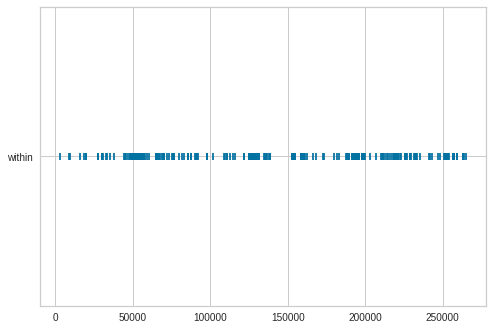

In [29]:
#Troubleshooting tokens to remove
dispersion_text = [doc.split() for doc in df_metadata["Clean_Content_Lemma_LongForm"]]

#Choose words whose occurence in the text will be plotted:
not_found = ["1TABLESANDFIGUREstatefigure","AND FIGUREStatefigure"]
other_words = [token.split() for token in ["within"]]
other_words_1D = np.unique(np.concatenate(other_words).reshape(-1))
target_words = other_words_1D

#Create the visualizer and draw the plot
visualizer = DispersionPlot(target_words,ignore_case=False)
_ = visualizer.fit(dispersion_text)

In [30]:
#Troubleshooting

#df_metadata["Clean_Content"].iloc[38].find("TMH")

#section = df_metadata["Clean_Content"].iloc[38]

#str(section)[1600:1750]

In [31]:
#Make sure spacy is not splitting on - or else terms may be lost such as e-mental
temp_doc = nlp("forensic e-mental Mr. Davis")
#Lemma Removes e-mental
[(token.text,token.lemma_)for token in temp_doc]

[('forensic', 'forensic'),
 ('e', 'e'),
 ('-', '-'),
 ('mental', 'mental'),
 ('Mr.', 'Mr.'),
 ('Davis', 'Davis')]

In [ ]:
#df_metadata["emental_Found"] = df_metadata["Content"].apply(lambda text: text.find("forensic emental health"))